In [24]:
import os
import numpy as np
import webdataset as wds
import matplotlib.pyplot as plt
import glob

subset_name = "0.0001"  # or "0.01percent", etc.
split_name = "train"  # "val", "test", ...
tars_path = f"../../data/jump_{subset_name}/{split_name}"

# Gather all .tar files in that directory
tar_files = sorted(glob.glob(os.path.join(tars_path, "*.tar")))
print(f"Found {len(tar_files)} tar files in {tars_path}:")
for tf in tar_files[:5]:
    print("  ", tf)
if not tar_files:
    raise ValueError(f"No .tar files found in {tars_path}")

dataset = (
    wds.WebDataset(tar_files)
    .shuffle(1000)  # small buffer shuffle
    .decode()  # no special decoder needed for "npy"
    .to_tuple("image.npy")  # yield only the NPY file
)

Found 7 tar files in ../../data/jump_0.0001/train:
   ../../data/jump_0.0001/train/shard_00000000.tar
   ../../data/jump_0.0001/train/shard_00000010.tar
   ../../data/jump_0.0001/train/shard_00000020.tar
   ../../data/jump_0.0001/train/shard_00000030.tar
   ../../data/jump_0.0001/train/shard_00000040.tar


/Users/lapuerta/miniconda3/envs/ldm/lib/python3.12/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


In [25]:
num_samples_to_visualize = 5
samples = []

for sample_idx, sample in enumerate(dataset):
    # sample is a tuple with a single element (the npy bytes)
    # "image" shape is (C,H,W)  =>  5 channels
    arr = sample[0]

    samples.append(arr)

    if sample_idx >= (num_samples_to_visualize - 1):
        break

print(f"Loaded {len(samples)} samples.")

Loaded 5 samples.


In [ ]:
#########################################
# 4. Visualize the channels
#########################################

# We'll assume that our 5 channels are in this order:
#   0 => RNA
#   1 => ER
#   2 => AGP
#   3 => Mito
#   4 => DNA
# You can rename or reorder as needed.

channel_names = ["RNA", "ER", "AGP", "Mito", "DNA"]


def show_sample_ch(arr, channel_names, int_percentile=99.9):
    """
    Displays each channel in a row of subplots.
    arr: shape (C, H, W)
    channel_names: e.g. ["RNA", "ER", "AGP", "Mito", "DNA"]
    """
    c, h, w = arr.shape
    fig, axes = plt.subplots(1, c, figsize=(4 * c, 4))

    # Make sure axes is iterable even if c=1
    if c == 1:
        axes = [axes]

    for i in range(c):
        # Rescale intensities for display
        vmax = np.percentile(arr[i], int_percentile)
        vmax = max(vmax, 1e-6)
        img_scaled = np.clip(arr[i] / vmax, 0, 1)

        axes[i].imshow(img_scaled, cmap="gray")
        cname = channel_names[i] if i < len(channel_names) else f"Ch{i}"
        axes[i].set_title(cname)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Let's display each of our loaded samples
for i, arr in enumerate(samples):
    print(f"Sample #{i}")
    show_sample_ch(arr, channel_names)

In [34]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import webdataset as wds


def show_sample_channels(arr, channel_names=None, int_percentile=99.9, rescale=True):
    """
    Displays each channel in a row of subplots.
    arr: shape (C, H, W)
    channel_names: e.g. ["RNA", "ER", "AGP", "Mito", "DNA"]
    int_percentile: percentile for intensity clipping (for display only)
    """
    if channel_names is None:
        # Default ordering if not provided
        channel_names = ["RNA", "ER", "AGP", "Mito", "DNA"]

    c, h, w = arr.shape
    fig, axes = plt.subplots(1, c, figsize=(4 * c, 4))

    # Make sure axes is iterable even if c=1
    if c == 1:
        axes = [axes]

    for i in range(c):
        if rescale:
            # Rescale intensities for display
            vmax = np.percentile(arr[i], int_percentile)
            vmax = max(vmax, 1e-6)
            img_scaled = np.clip(arr[i] / vmax, 0, 1)
            ax = axes[i]
            ax.imshow(img_scaled, cmap="gray")
            # channel name (use fallback if we have fewer channel_names than channels)
            ch_name = channel_names[i] if i < len(channel_names) else f"Ch{i}"
            ax.set_title(ch_name)
            ax.axis("off")
        else:
            axes[i].imshow(arr[i], cmap="gray")
            cname = channel_names[i] if i < len(channel_names) else f"Ch{i}"
            axes[i].set_title(cname)
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()


def visualize_samples_from_subset(
    subset_name="0.0001",
    split="train",
    num_samples=10,
    shuffle_buffer=1000,
    base_path="../../data",
    channel_names=None,
    rescale=True,
):
    """
    1) Finds all .tar files for the specified subset and split.
    2) Creates a WebDataset pipeline that yields 5-channel images.
    3) Samples `num_samples` items from the dataset.
    4) Visualizes each sample side-by-side in a row of subplots.

    Args:
        subset_name (str): e.g. "0.001percent"
        split (str): "train", "val", or "test"
        num_samples (int): how many samples to visualize
        shuffle_buffer (int): how many items to shuffle in memory
        base_path (str): top-level directory containing the subset folders
        channel_names (list of str or None): channel names, e.g. ["RNA", "ER", ...]
    """
    if channel_names is None:
        channel_names = ["RNA", "ER", "AGP", "Mito", "DNA"]

    tars_path = os.path.join(base_path, f"jump_{subset_name}", split)
    tar_files = sorted(glob.glob(os.path.join(tars_path, "*.tar")))
    if not tar_files:
        raise ValueError(f"No .tar files found in {tars_path}")
    print(f"Found {len(tar_files)} tar files in {tars_path}")

    dataset = (
        wds.WebDataset(tar_files)
        .shuffle(shuffle_buffer)  # shuffle a bit
        .decode()  # decode .npy into a NumPy array
        .to_tuple("image.npy")  # yield (arr,) for each sample
    )

    samples = []
    for sample_idx, sample in enumerate(dataset):
        arr = sample[0]  # The array is already decoded: shape (5, H, W)
        samples.append(arr)
        if len(samples) >= num_samples:
            break

    if not samples:
        print("No samples retrieved from dataset!")
        return
    else:
        print(f"Loaded {len(samples)} samples.")

    for i, arr in enumerate(samples):
        print(f"Sample #{i+1}")
        show_sample_channels(arr, channel_names=channel_names, rescale=rescale)

Found 7 tar files in ../../data/jump_0.0001/train
Loaded 10 samples.
Sample #1


/Users/lapuerta/miniconda3/envs/ldm/lib/python3.12/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


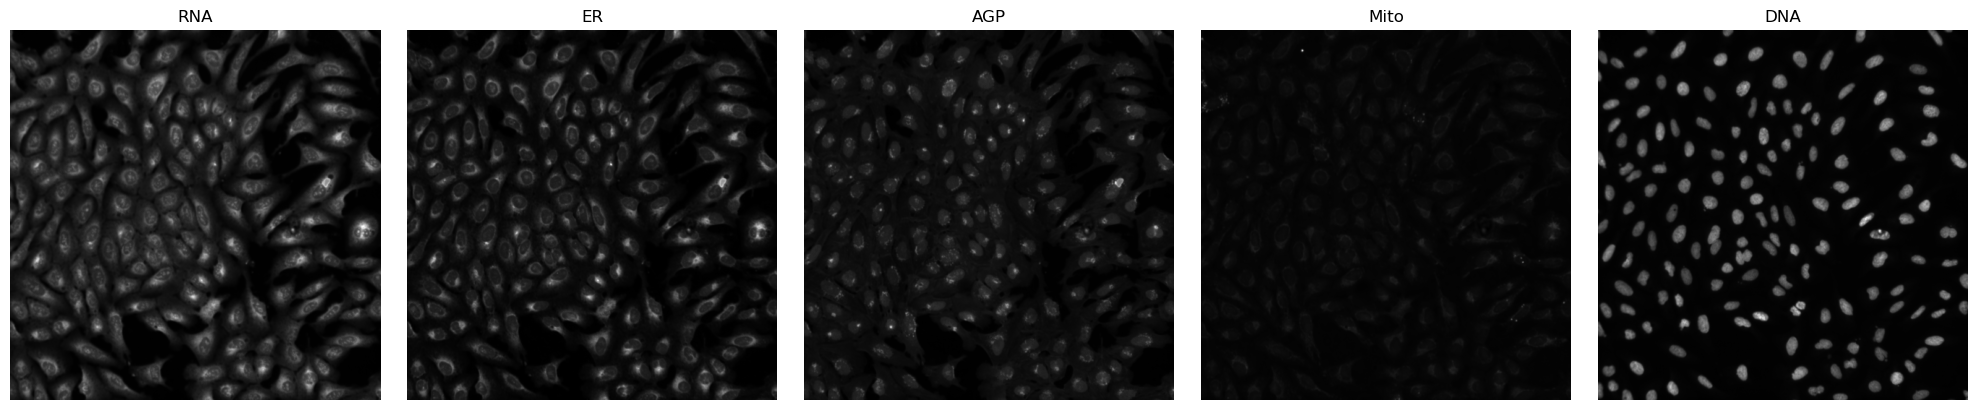

Sample #2


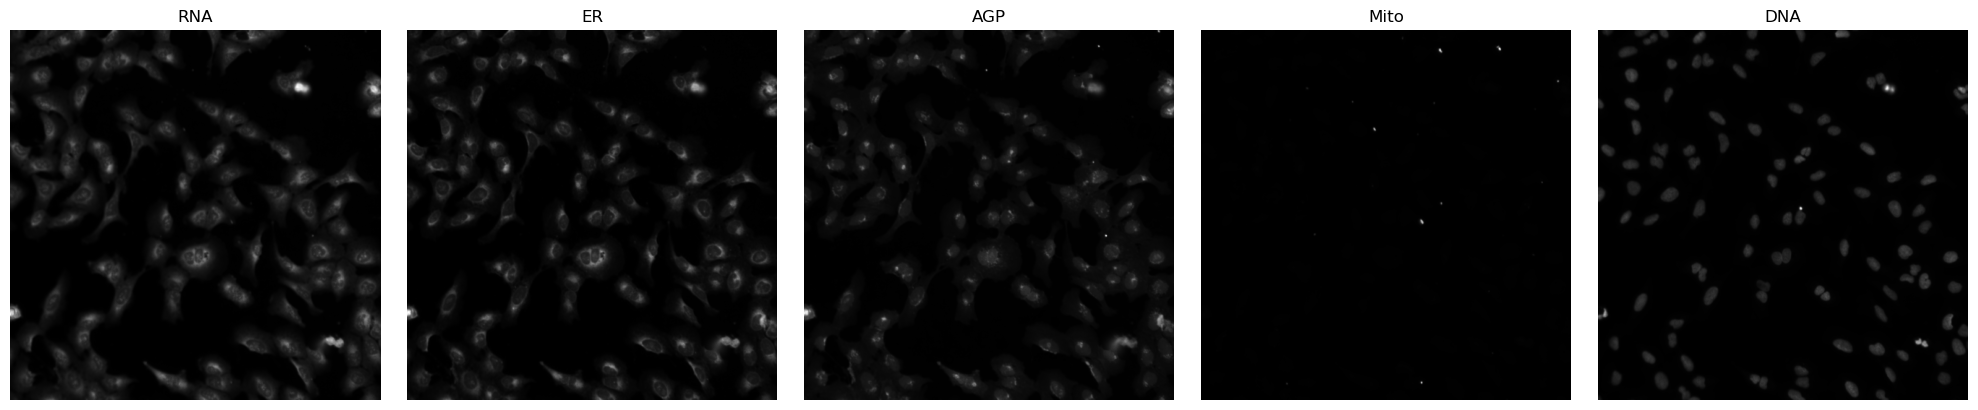

Sample #3


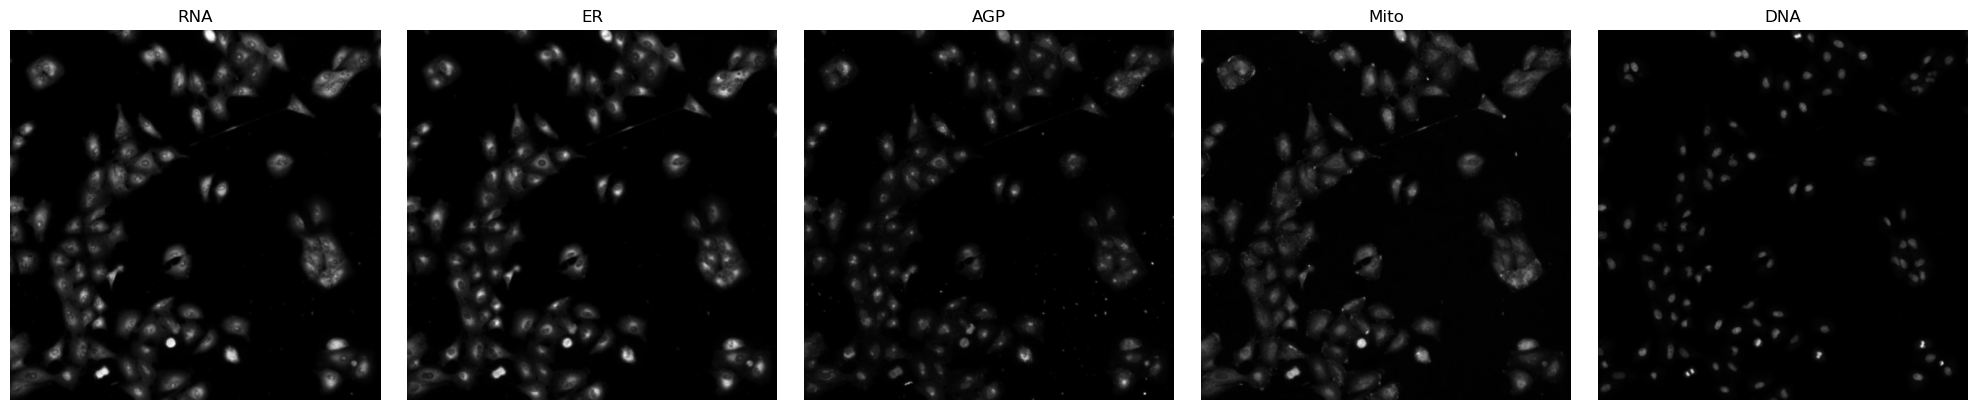

Sample #4


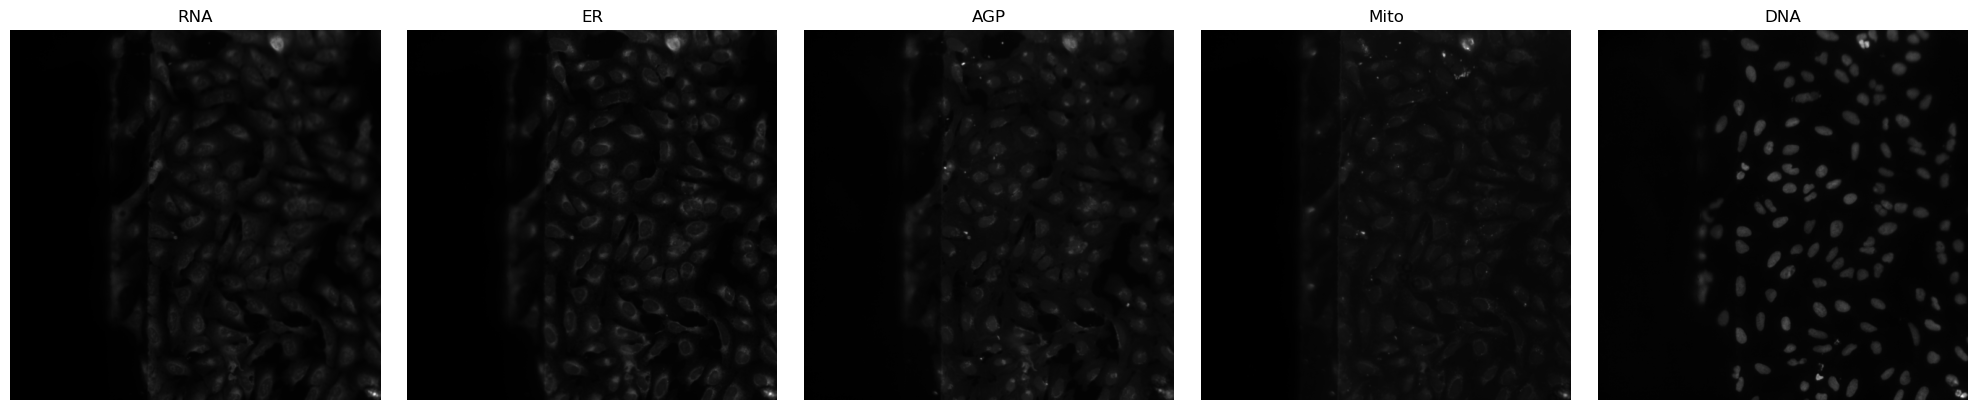

Sample #5


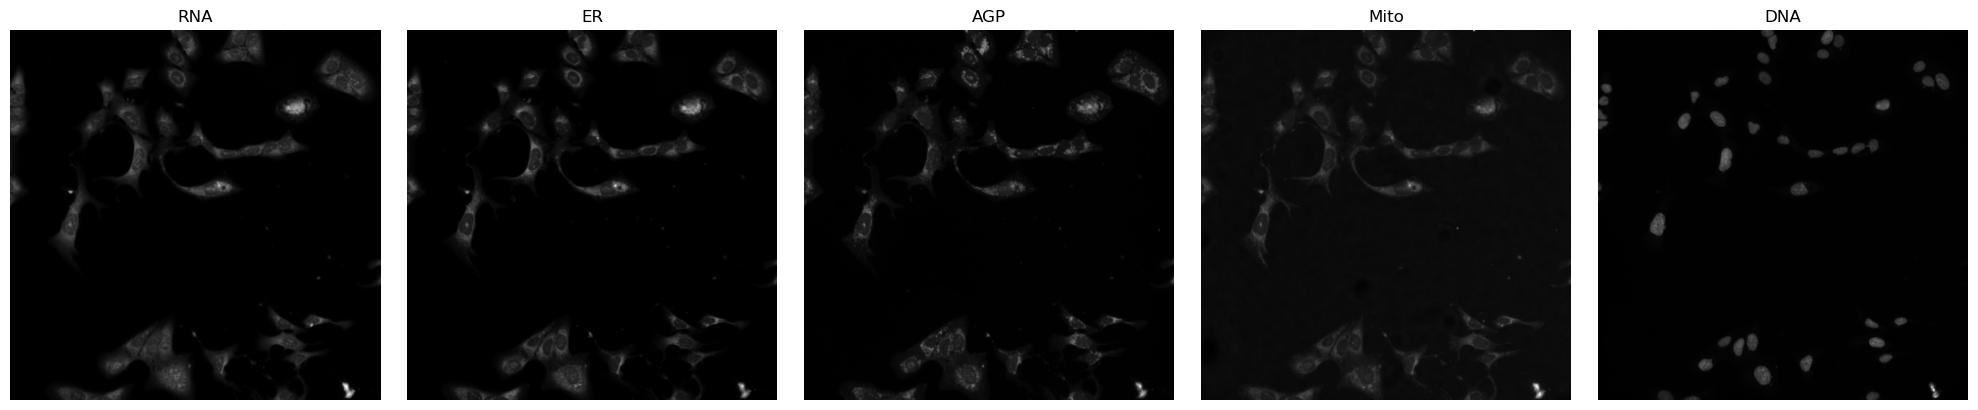

Sample #6


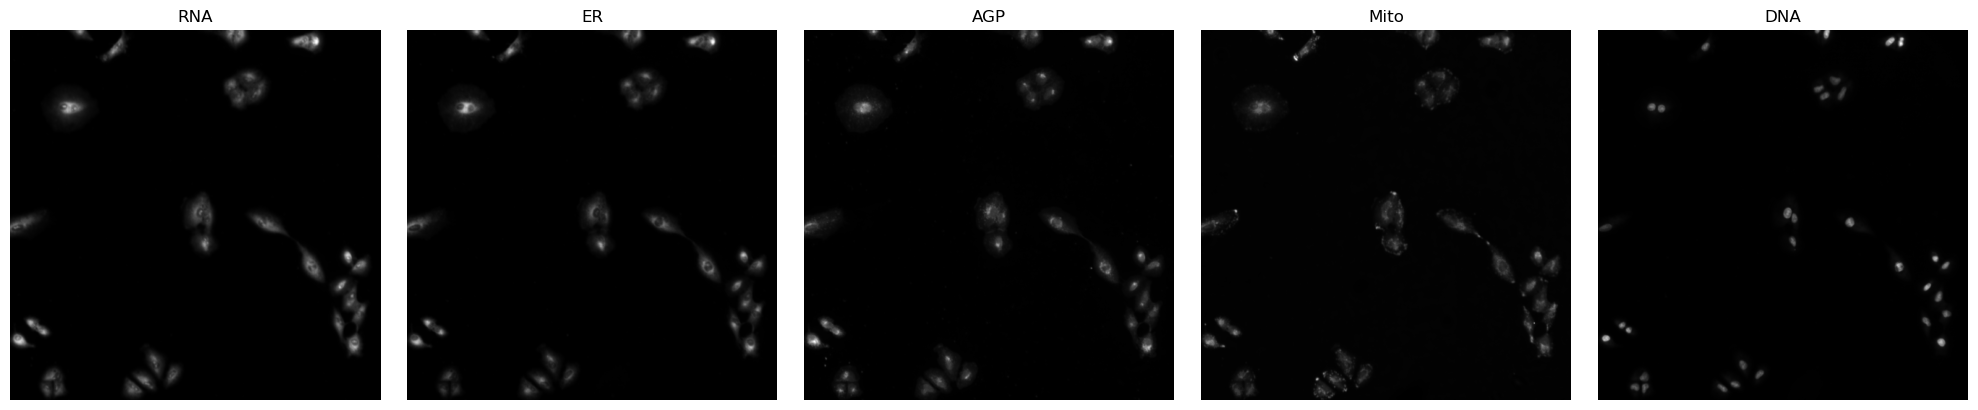

Sample #7


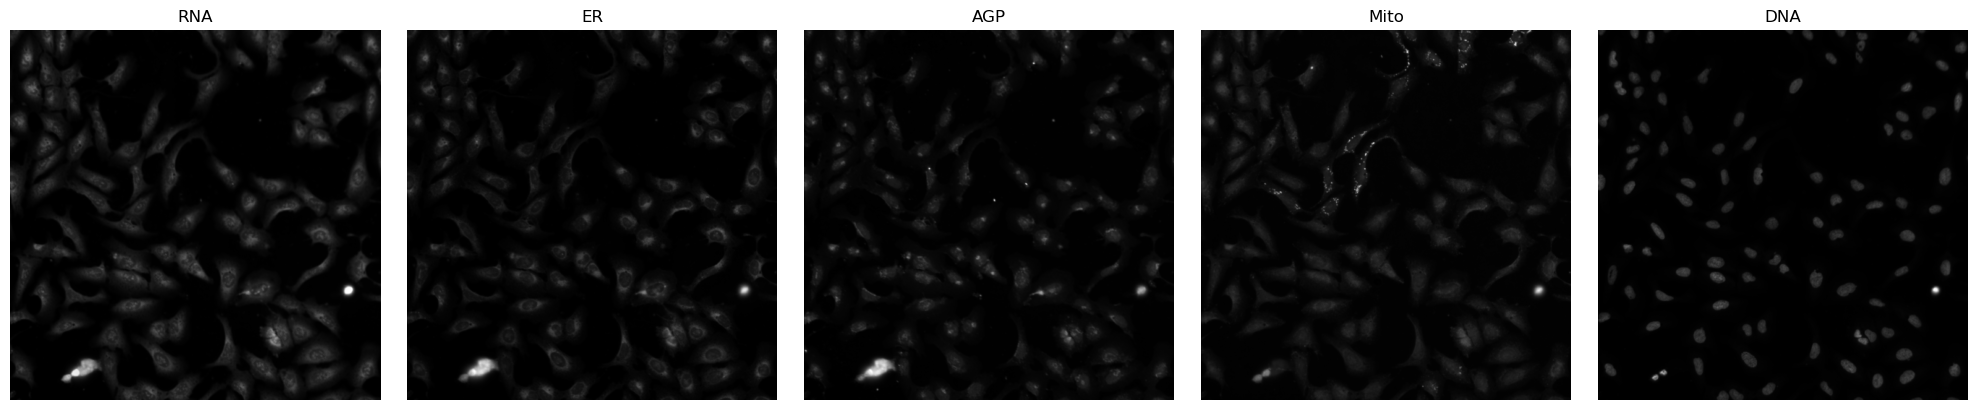

Sample #8


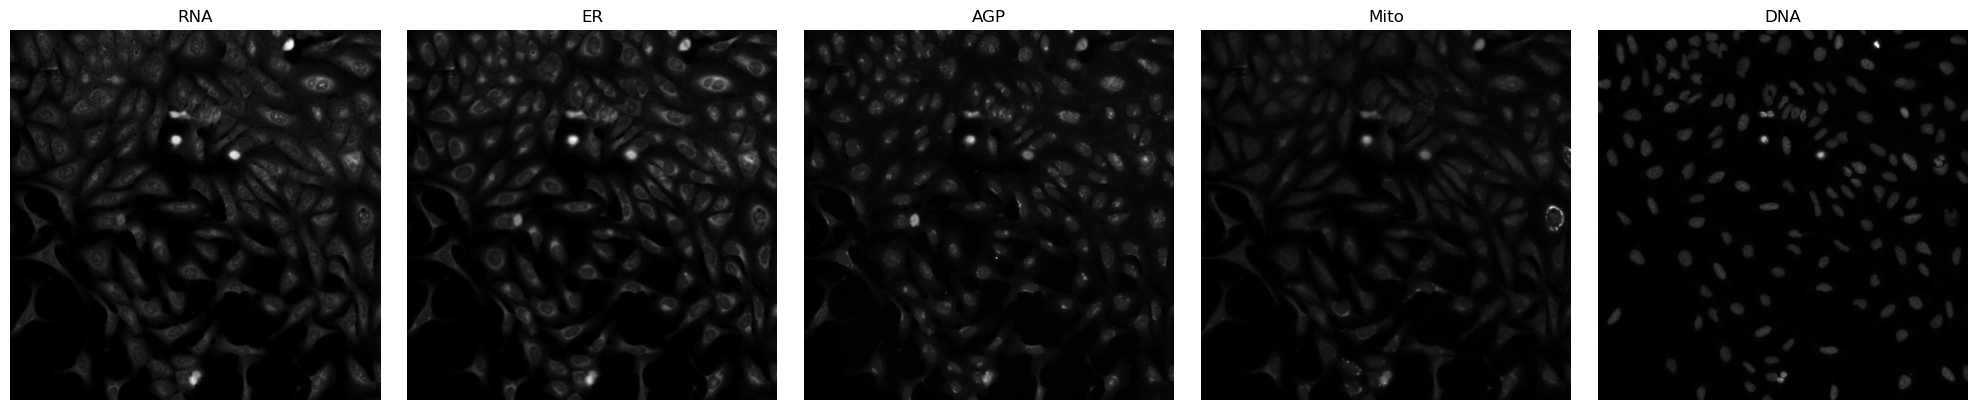

Sample #9


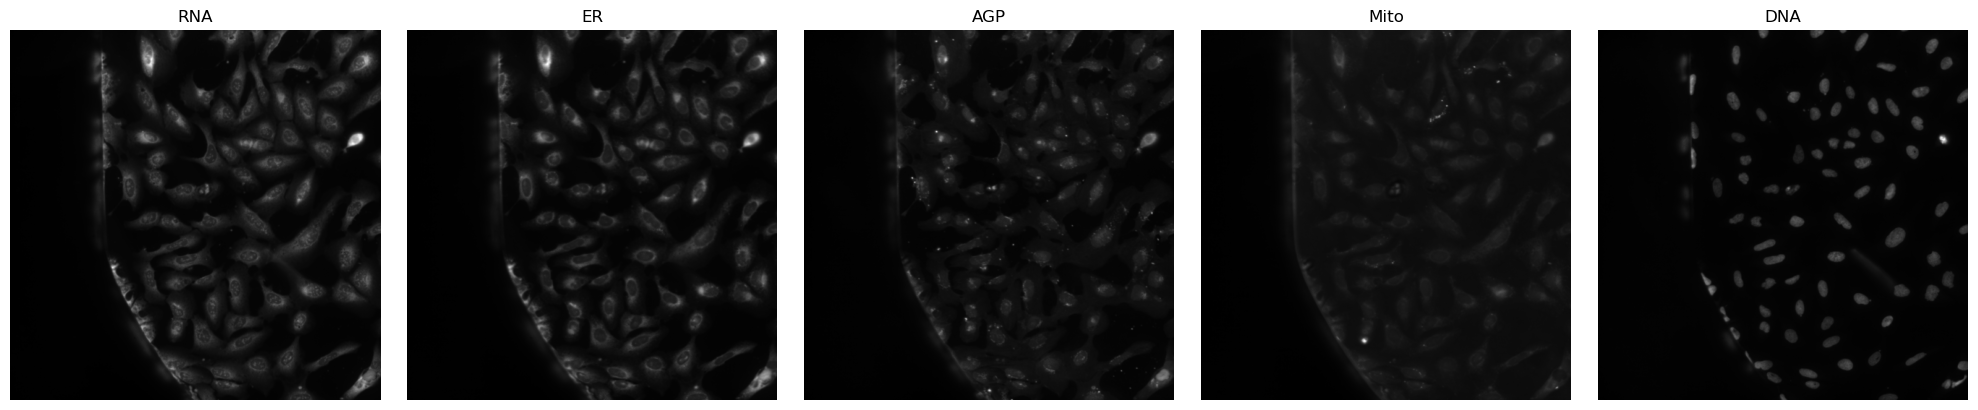

Sample #10


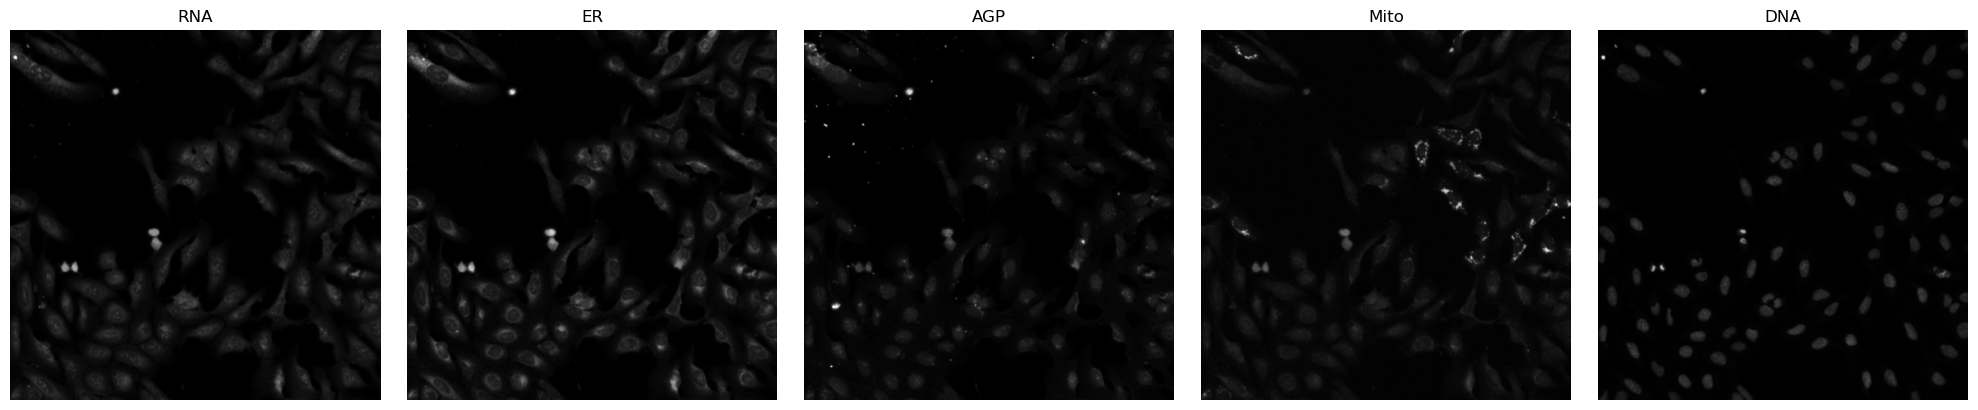

In [39]:
# In a cell:
visualize_samples_from_subset(
    subset_name="0.0001",
    split="train",
    num_samples=10,
    base_path="../../data",
    channel_names=["RNA", "ER", "AGP", "Mito", "DNA"],
    rescale=False,
)

Everything looks fine. We have not normalized yet, right?


In [42]:
import numpy as np

# We'll assume you already have a dataset pipeline like:
# dataset = wds.WebDataset(tar_files).decode("npy").to_tuple("image.npy")

tars_path = os.path.join("../../data", f"jump_{subset_name}", "train")
tar_files = sorted(glob.glob(os.path.join(tars_path, "*.tar")))
if not tar_files:
    raise ValueError(f"No .tar files found in {tars_path}")
print(f"Found {len(tar_files)} tar files in {tars_path}")

dataset = (
    wds.WebDataset(tar_files)
    .decode()  # decode .npy into a NumPy array
    .to_tuple("image.npy")  # yield (arr,) for each sample
)

# 1) Grab just one sample
sample = next(iter(dataset))
arr = sample[0]  # shape = (5, H, W) if you have 5 channels

# 2) Print shape info
print(f"Loaded one image with shape {arr.shape}")

# 3) Let's define channel names for convenience
channel_names = ["RNA", "ER", "AGP", "Mito", "DNA"]

# 4) Print mean, std, min, max for each channel
for i, ch_name in enumerate(channel_names):

    ch_data = arr[i]  # 2D slice for this channel
    mean_val = ch_data.mean()
    std_val = ch_data.std()
    min_val = ch_data.min()
    max_val = ch_data.max()

    print(f"Channel '{ch_name}':")
    print(f"  Mean = {mean_val:.4f}")
    print(f"  Std  = {std_val:.4f}")
    print(f"  Min  = {min_val:.4f}")
    print(f"  Max  = {max_val:.4f}\n")

Found 7 tar files in ../../data/jump_0.0001/train
Loaded one image with shape (5, 512, 512)
Channel 'RNA':
  Mean = 2346.1121
  Std  = 2237.5576
  Min  = 349.2312
  Max  = 26860.4941

Channel 'ER':
  Mean = 1272.3015
  Std  = 1198.1201
  Min  = 265.8819
  Max  = 13239.0117

Channel 'AGP':
  Mean = 1887.4218
  Std  = 1630.0356
  Min  = 450.3625
  Max  = 23069.4902

Channel 'Mito':
  Mean = 2038.7095
  Std  = 951.7130
  Min  = 870.6981
  Max  = 37161.4336

Channel 'DNA':
  Mean = 767.7419
  Std  = 1062.7986
  Min  = 244.4360
  Max  = 21578.5898

